In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
#understand the data#######################################################

In [4]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

health = pd.read_csv("newborn_health_monitoring_with_risk.csv")

In [5]:
health.head()

,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,age_days,weight_kg,length_cm,temperature_c,heart_rate_bpm,risk_level
0,Female,40.2,3.3,50.0,1,3.28,50.1,37.0,160,At Risk
1,Female,40.2,3.3,50.0,2,3.35,50.2,37.2,156,At Risk
2,Female,40.2,3.3,50.0,3,3.35,50.6,37.1,137,Healthy
3,Female,40.2,3.3,50.0,4,3.48,50.3,37.4,130,Healthy
4,Female,40.2,3.3,50.0,5,3.50,50.3,36.8,138,At Risk


In [6]:
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 3000 non-null   object 
 1   gestational_age_weeks  3000 non-null   float64
 2   birth_weight_kg        3000 non-null   float64
 3   birth_length_cm        3000 non-null   float64
 4   age_days               3000 non-null   int64  
 5   weight_kg              3000 non-null   float64
 6   length_cm              3000 non-null   float64
 7   temperature_c          3000 non-null   float64
 8   heart_rate_bpm         3000 non-null   int64  
 9   risk_level             3000 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 234.5+ KB


In [7]:
health["risk_level"].value_counts()

risk_level
Healthy    2602
At Risk     398
Name: count, dtype: int64

In [8]:
health.describe()

,gestational_age_weeks,birth_weight_kg,birth_length_cm,age_days,weight_kg,length_cm,temperature_c,heart_rate_bpm
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,38.878000,3.205000,49.727000,15.500000,3.669730,50.508000,37.002933,139.682000
std,1.570076,0.561555,2.145065,8.656884,0.621355,2.196846,0.310747,10.139386
min,35.400000,1.860000,45.100000,1.000000,1.790000,45.000000,35.800000,100.000000
25%,37.800000,2.870000,48.475000,8.000000,3.220000,49.100000,36.800000,133.000000
50%,38.800000,3.165000,49.550000,15.500000,3.660000,50.400000,37.000000,140.000000
75%,40.100000,3.625000,51.025000,23.000000,4.100000,51.800000,37.200000,146.000000
max,43.000000,4.470000,55.800000,30.000000,5.410000,57.400000,38.100000,173.000000


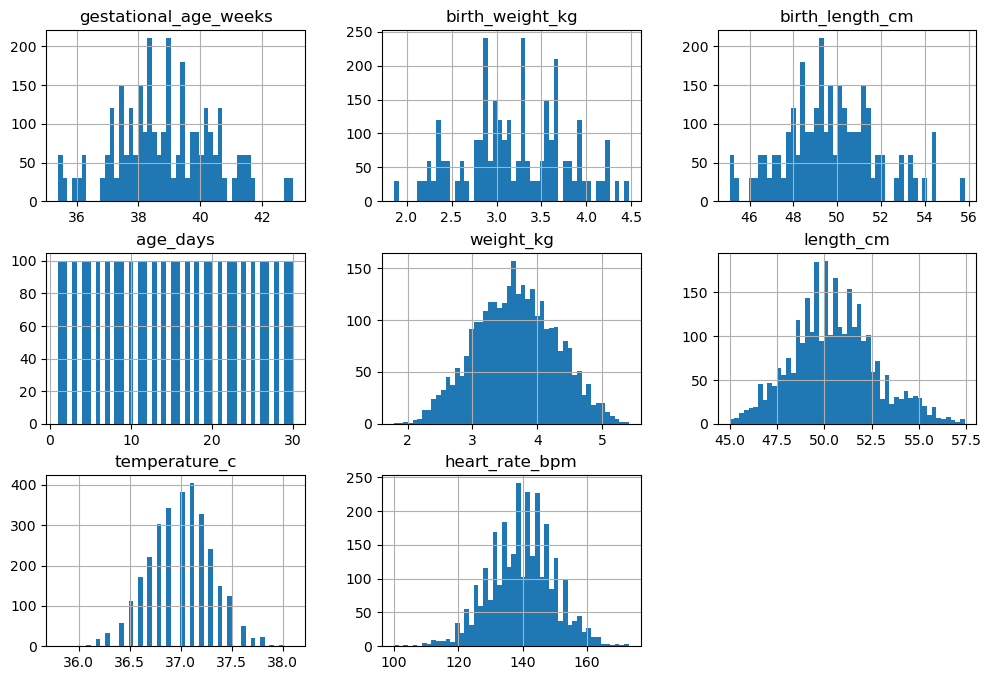

In [10]:
import matplotlib.pyplot as plt

health.hist(bins=50, figsize=(12, 8))
plt.show()

In [22]:
#Create a Test Set#########################################################

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(health, test_size=0.2, random_state=42)
len(train_set)

2400

In [12]:
len(test_set)

600

In [13]:
health_copy = health.copy()

In [14]:
#visualize data#####################################################################

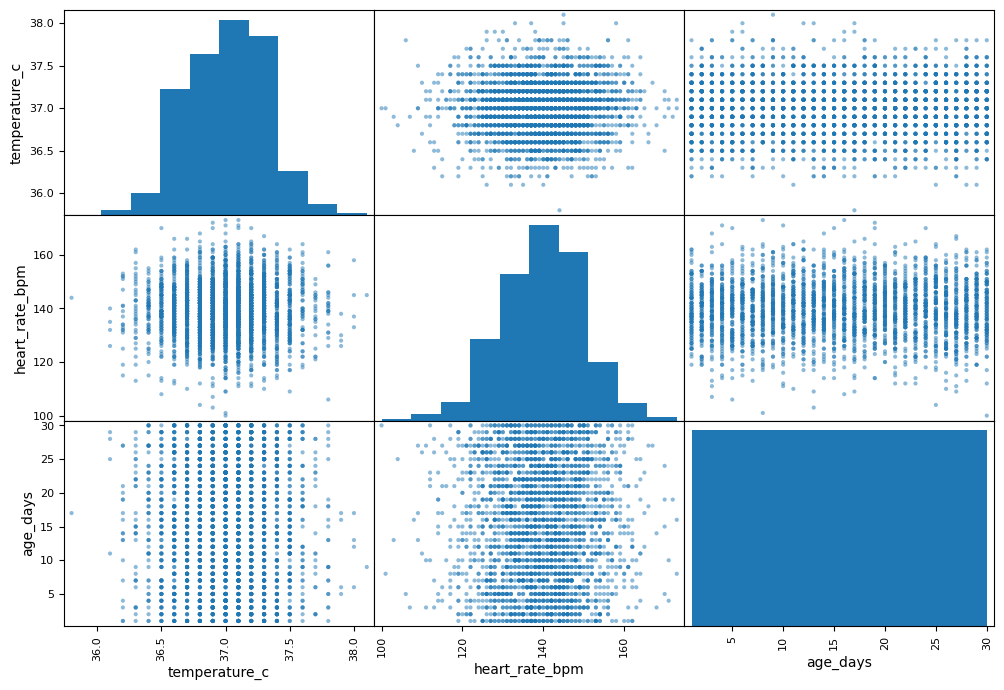

In [15]:
from pandas.plotting import scatter_matrix

attributes = ["temperature_c", "heart_rate_bpm", "age_days"]
scatter_matrix(health[attributes], figsize=(12, 8))
plt.show()

In [16]:
train_set_att = train_set.drop("risk_level", axis=1)
train_set_label = train_set[["risk_level"]].copy()

In [17]:
train_set_label.head(8)

,risk_level
642,Healthy
700,Healthy
226,Healthy
1697,Healthy
1010,Healthy
1572,Healthy
776,Healthy
1730,Healthy


In [18]:
sklearn.set_config(display="diagram")

In [19]:
from sklearn import set_config

set_config(display='diagram')

In [20]:
#make pipeline and necessary transformations############################################

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

num_attribs = ["gestational_age_weeks", "birth_weight_kg", "birth_length_cm", "age_days",
               "weight_kg", "length_cm", "temperature_c", "heart_rate_bpm"]
cat_attribs = ["gender"]

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OrdinalEncoder())

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [22]:
health_prepared = preprocessing.fit_transform(train_set_att)

In [23]:
len(health_prepared)

2400

In [24]:
health_prepared_fr = pd.DataFrame(
    health_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=train_set_att.index)
health_prepared_fr.head(2)

,num__gestational_age_weeks,num__birth_weight_kg,num__birth_length_cm,num__age_days,num__weight_kg,num__length_cm,num__temperature_c,num__heart_rate_bpm,cat__gender
642,0.532501,-0.574883,-1.591782,-0.287411,-0.597627,-1.680769,-0.016213,0.914521,0.0
700,0.911561,-1.568547,0.778636,-0.517878,-1.683510,0.496892,0.956561,0.323342,1.0


In [25]:
## train a logistic regression model #############################################

In [26]:
ordinal_encoder_risk = OrdinalEncoder()

train_set_label_encoded = ordinal_encoder_risk.fit_transform(train_set_label)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

log_reg = make_pipeline(preprocessing, LogisticRegression())
y_train = train_set_label_encoded.ravel()
log_reg.fit(train_set_att, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [28]:
len(y_train)

2400

In [29]:
health_predictions = log_reg.predict(train_set_att)

In [30]:
import numpy as np
health_predictions
value_to_find = 0

# Create a boolean array where True means the value matches
boolean_mask = (health_predictions == value_to_find)

# Count the number of True values (non-zero)
count = np.count_nonzero(boolean_mask)

print(f"The value {value_to_find} appears {count} times.")

The value 0 appears 57 times.


In [31]:
import numpy as np

y_train

value_to_find = 0

# Create a boolean array where True means the value matches
boolean_mask = (y_train == value_to_find)

# Count the number of True values (non-zero)
count = np.count_nonzero(boolean_mask)

print(f"The value {value_to_find} appears {count} times.")

The value 0 appears 322 times.


In [32]:
# train a decision tree regressor model #####################################

In [33]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))

tree_reg.fit(train_set_att, y_train)
health_predictions = tree_reg.predict(train_set_att)

In [54]:
train_set_att.head(2)

,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,age_days,weight_kg,length_cm,temperature_c,heart_rate_bpm
642,Female,39.7,2.88,46.3,13,3.30,46.8,37.0,149
700,Male,40.3,2.32,51.4,11,2.63,51.6,37.3,143


In [34]:
# fine tune the decision tree regrossor model ######################################

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

# Define the model to be tuned
full_pipeline = make_pipeline(preprocessing, DecisionTreeClassifier(random_state=42))

param_distribs = {
    # Use the new step name as the prefix
    'decisiontreeclassifier__max_depth': randint(low=1, high=20),
    'decisiontreeclassifier__max_features': randint(low=1, high=10),
    'decisiontreeclassifier__min_samples_split': randint(low=2, high=20),
}

# Step 4: Set up the randomized search with a classification scoring metric
rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distribs,
    n_iter=10,
    cv=5,
    # Use 'f1' as a robust metric for imbalanced classification
    scoring='f1',
    random_state=42
)

rnd_search.fit(train_set_att, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'decisiontreeclassifier__max_depth': <scipy.stats....x7590a9d82980>, 'decisiontreeclassifier__max_features': <scipy.stats....x7590a9d82710>, 'decisiontreeclassifier__min_samples_split': <scipy.stats....x7590a98fceb0>}"
,n_iter,10
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [52]:
import joblib


MODEL_FILENAME = 'my_health_classifier.joblib' 

joblib.dump(rnd_search, MODEL_FILENAME)
print(f"Model successfully saved as: {MODEL_FILENAME}")

Model successfully saved as: my_health_classifier.joblib


In [1]:
#generate the onnx
import skl2onnx

ModuleNotFoundError: No module named 'skl2onnx'

In [2]:
from skl2onnx import convert_sklearn, to_onnx
from skl2onnx.common.data_types import FloatTensorType

# Load the trained model from the file created in Step 1
MODEL_FILENAME = 'my_health_classifier.joblib'
scikit_model = joblib.load(MODEL_FILENAME)

# --- CRITICAL: Define the model's input structure ---
# You MUST tell ONNX the name and shape of your data's input features.
# The 'None' means the number of rows (samples) is unknown (can be 1 or many).
# The '4' must be replaced by the exact number of features (columns) your model takes.
# Based on common scikit-learn models, we assume floating-point input (FloatTensorType).

# **You need to adjust the number '4' below to match your feature count!**
initial_type = [('float_input', FloatTensorType([1, 9]))] 

# Convert the scikit-learn model object into the ONNX format
onx = convert_sklearn(
    scikit_model,
    initial_types=initial_type,
    target_opset=17, # Using a common ONNX operator set
    options={type(scikit_model): {"zipmap": False}}
)

# Save the ONNX model to the final file
ONNX_FILENAME = "health_classifier.onnx"
with open(ONNX_FILENAME, "wb") as f:
    f.write(onx.SerializeToString())

print(f"ONNX model successfully converted and saved as: {ONNX_FILENAME}")

ModuleNotFoundError: No module named 'skl2onnx'

In [36]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_reg.fit(train_set_att, y_train)
health_predictions = forest_reg.predict(train_set_att)

In [37]:
## Testing results

In [38]:
test_set_att = test_set.drop("risk_level", axis=1)
test_set_label = test_set[["risk_level"]].copy()

In [39]:
health_prepared = preprocessing.fit_transform(test_set_att)

In [40]:
ordinal_encoder_risk = OrdinalEncoder()
test_set_label_encoded = ordinal_encoder_risk.fit_transform(test_set_label)
y_test = test_set_label_encoded.ravel()

In [47]:
health_predictions = log_reg.predict(test_set_att)

In [49]:
health_predictions = rnd_search.predict(test_set_att)
health_predictions

array([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1.

In [43]:
import numpy as np



# Create a boolean array where True means the value matches
boolean_mask = (y_test == 0)

# Count the number of True values (non-zero)
count = np.count_nonzero(boolean_mask)
print(f"The value 0 appears {count} times.")

# Create a boolean array where True means the value matches
boolean_mask = (y_test == 1)

# Count the number of True values (non-zero)
count = np.count_nonzero(boolean_mask)
print(f"The value 1 appears {count} times.")

The value 0 appears 76 times.
The value 1 appears 524 times.


In [44]:
import numpy as np



# Create a boolean array where True means the value matches
boolean_mask = (health_predictions == 0)

# Count the number of True values (non-zero)
count = np.count_nonzero(boolean_mask)
print(f"The value 0 appears {count} times.")

# Create a boolean array where True means the value matches
boolean_mask = (health_predictions == 1)

# Count the number of True values (non-zero)
count = np.count_nonzero(boolean_mask)
print(f"The value 1 appears {count} times.")

The value 0 appears 81 times.
The value 1 appears 519 times.


In [50]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, health_predictions)
print(f"The model's accuracy is: {accuracy:.4f}")

The model's accuracy is: 0.9150


In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, health_predictions)
print(cm)


[[ 53  23]
 [ 28 496]]


In [212]:
#[[True Negatives, False Positives],
# [False Negatives, True Positives]]